## CO2RR 공정 datasheet 분석

----------------------------------

-------

Output 중 Required energy_total (MJ/kgCO), MSP 분석 예정

step0. 라이브러리 정리

In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from kan import KAN
from kan.utils import ex_round
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
import os

step1. 엑셀 파일 불러오기

In [5]:
# 엑셀 데이터 로드 
filepath = os.path.join(os.getcwd(), "25.01.14_CO2RR_GSA.xlsx")

# filepath = r"C:\Users\kepco201\Desktop\KAN_python\pykan-master\github\workflows\TaeWoong\25.01.14_CO2RR_GSA.xlsx"
xls = pd.ExcelFile(filepath)
df_in  = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')



step2.결측값 대체 및 이상치 제거

이상치(Outlier) 제거 / 전체 데이터의 10% 이내로 극소량만 제거

In [6]:
# 이상치(Outlier) 제거 (IQR 방식) ---

print("--- 이상치 제거 시작 ---")


print(f"이상치 제거 전 데이터 수: {len(df_in)} 개")   # len(df_in) 을 통해 이상치 제거 전 데이터 길이(개수) 출력


def remove_outliers_iqr(df_in, df_out):              # outlier 제거 함수 정의
    
    combined_df = pd.concat([df_in, df_out], axis=1) # pd.concat = 2개를 합치기 // 입력 변수(X)와 출력 변수(y)를 합쳐서 전체 데이터프레임 생성 // x랑 y를 한번에 고려
                                                     # axis = 1 --- 오른쪽으로 합치기 --- 데이터 구조를 보면 예쁘게 정리가 된다
    
    numeric_cols = combined_df.select_dtypes(include=np.number).columns  # .select_dtypes 를 통해 특정 열만 출력 outlier 를 탐지할 숫자형 컬럼만 선택
                                    # numeric_cols = 숫자로만 구성된 열들의 이름 리스트 (.colums = 그 열의 이름을 리스트로 출력)

    # 각 컬럼에 대해 이상치 경계 계산 
    Q1 = combined_df[numeric_cols].quantile(0.25)   # .quantile(0.25) = 데이터를 오름차순으로 정렬했을 떄 하위 25% 지점 
    Q3 = combined_df[numeric_cols].quantile(0.75)   # .quantile(0.75) = 데이터를 오름차순으로 정렬했을 떄 상위 25% 지점 
    IQR = Q3 - Q1 # IQR은 대략 상위 25% - 상위75% = 중간정도의 값에 해당
    
    lower_bound = Q1 - 6 * IQR  # 보통은 1.5* IQR을 진행하지만 최대한 삭제되는 데이터가 적도록 진행
    upper_bound = Q3 + 6 * IQR
    

    # 밑의 줄은 공부를 더 해보자
    # 모든 컬럼에 대해 정상 범위 내에 있는 데이터만 True로 표시
    # (row의 어떤 컬럼이라도 이상치면 해당 row 전체가 False가 됨)
    condition = ~((combined_df[numeric_cols] < lower_bound) | (combined_df[numeric_cols] > upper_bound)).any(axis=1)
    

    # 정상 범위에 있는 데이터만 필터링
    df_in_no_outliers = df_in[condition]
    df_out_no_outliers = df_out[condition]
    
    return df_in_no_outliers, df_out_no_outliers

# 3. 함수를 사용하여 이상치 제거
#    이전에 결측치를 제거한 df_in_cleaned, df_out_cleaned를 사용합니다.
df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)


# 4. 이상치 제거 후 남은 데이터 개수 확인
removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")


# 이제 'df_in_final'과 'df_out_final'을 사용하자

# 으아...할 일이 많군


# 입력 변수(X) 선택 - 엑셀파일에서 불러옴
X = df_in_final[[
    "Current density (mA/cm2)", 
    "Faradaic efficiency (%)", 
    "CO coversion",
    "Voltage (V)", 
    "Electricity cost ($/kWh)", 
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", 
    "Crossover rate"
]].values

predicting = "Required energy_total (MJ/kgCO)" # 다른 output 변수 보고싶으면 이거 보면 됨 # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
###### 이거를 수정해서 다른 output도 보자

y = df_out_final[predicting].values.reshape(-1, 1)   # df_out_final[] 는 pandas datatframe이기에 이것을 skitlearn 이나 Keras 형태로 바꾸기 -- 그래야 
                                                     # .values 를 통해 Numpy 배열로 변환 (값만 뽑기 때문) # 그 후에 reshape(-1.1) 을 통해 
                                                     # .reshape()을 이용해 열 1








# 1단계: 먼저 train+val과 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2단계: train+val을 train과 val로 분할 (64:16, 전체 대비)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)


# 최종 비율 확인
# (X[:,0])~(X[:,7]) 에 각각의 입력변수들의 값들이 각각 저장됨




print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")  
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

from sklearn.preprocessing import MinMaxScaler
import numpy as np



# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))




X_train_norm = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train) # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

# 3. 학습된 스케일러로 검증 및 테스트 데이터 변환 (transform)
# X_train의 기준으로 나머지 데이터들을 변환합니다.
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)   # y_val 과 y_test 도 y_train 의 정규분포를 따라 변환된다
y_test_norm = scaler_y.transform(y_test)

# 딥러닝을 진행하기 전 모든 데이터셋을 tensor로 변환  # 원래는 numpy 배열이었음 --- 아까 scikitlearn의 train test split 이나 .fit transform 스케일러를 사용하였기에 
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32, device=device)

print(f"모든 텐서가 {device}에 배치됨")

# 나중에 정의하기 편하게 dataset을 정의하기 -- 참고로 dataset들은 tensor 이다

dataset = {'train_input': X_train_tensor,'train_label': y_train_tensor,
            'val_input': X_val_tensor, 'val_label': y_val_tensor,
            'test_input': X_test_tensor,'test_label': y_test_tensor }    # dataset dictionary에 key값과 value 값을 설정한다

# 데이터셋 검토차 크기 확인
for key, value in dataset.items():                     #.items()를 쓰면 key와 value 값을 묶어서 출력 // .items()가 없으면 오직 key만 출력
    print(f"{key}: {value.shape}")


--- 이상치 제거 시작 ---
이상치 제거 전 데이터 수: 2501 개
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---

전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)
모든 텐서가 cpu에 배치됨
train_input: torch.Size([1521, 8])
train_label: torch.Size([1521, 1])
val_input: torch.Size([381, 8])
val_label: torch.Size([381, 1])
test_input: torch.Size([476, 8])
test_label: torch.Size([476, 1])


### step이 많아서 따로따로 보면 피곤해서 ci 파라미터 출력할때는 아래의 step들을 합쳐서 위에 하나의 코드 칸에 써놓음

이상치 제거 후 X, Y 정의하기

step3. 엑셀 파일 속 data 추출 및 !predict 할 데이터 이름 입력!

step4. train_set, valadation_set, test_set 만들기 (64:16:20) 우측 하단 RAW로 일단 설정해놓음 나중에 python으로 바꾸기

step5. 데이터 정규화(normalization)_전처리 과정

step6. tensor 변환

step7. dataset dictionary 만들기

step8. 1개의 KAN 모델 생성

In [7]:
# KAN 모델 생성
model = KAN(width=[8,12,1], grid=3, k=3, seed=42, device=device)   

checkpoint directory created: ./model
saving model version 0.0


In [8]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"학습가능 파라미터 수: {num_params:,}")

for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name:40s} {p.shape} {p.numel():5d}")

학습가능 파라미터 수: 1,296
act_fun.0.coef                           torch.Size([8, 12, 6])   576
act_fun.0.scale_base                     torch.Size([8, 12])    96
act_fun.0.scale_sp                       torch.Size([8, 12])    96
act_fun.1.coef                           torch.Size([12, 1, 6])    72
act_fun.1.scale_base                     torch.Size([12, 1])    12
act_fun.1.scale_sp                       torch.Size([12, 1])    12
symbolic_fun.0.affine                    torch.Size([12, 8, 4])   384
symbolic_fun.1.affine                    torch.Size([1, 12, 4])    48


step9. KAN 학습

| train_loss: 2.29e-02 | test_loss: 2.54e-02 | reg: 2.79e+00 | : 100%|█| 50/50 [00:21<00:00,  2.37it


saving model version 0.1


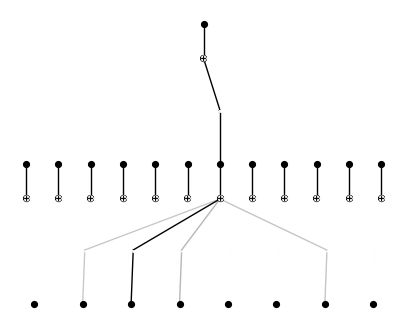

In [9]:
# KAN 학습
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)
model.plot()

basis function에 곱해지는 파라미터 ci의 리스트를 나열해보자

In [10]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)





layer 0의 전체 ci tensor 크기 
torch.Size([8, 12, 6])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.028528496623039246, 0.02972731739282608, 0.032018207013607025, 0.03469417989253998, 0.0379110723733902, 0.04064672440290451]


In [11]:
#pruning
model = model.prune(node_th=1e-2, edge_th=3e-2)  # 더 자르고 싶으면 값을 높이고, 덜 자르고 변수를 많이 있게 하고 싶으면 값을 낮추기

#학습
model.fit(dataset, opt="LBFGS", steps=50)  # update_grid 가 False일때랑 True일때의 차이는?


saving model version 0.2


| train_loss: 1.42e-02 | test_loss: 1.46e-02 | reg: 4.28e+00 | : 100%|█| 50/50 [00:04<00:00, 11.18it

saving model version 0.3


{'train_loss': [array(0.0282163, dtype=float32),
  array(0.01933612, dtype=float32),
  array(0.01629475, dtype=float32),
  array(0.01579578, dtype=float32),
  array(0.01539089, dtype=float32),
  array(0.01478221, dtype=float32),
  array(0.014364, dtype=float32),
  array(0.01429628, dtype=float32),
  array(0.01425976, dtype=float32),
  array(0.01425182, dtype=float32),
  array(0.01425101, dtype=float32),
  array(0.01424445, dtype=float32),
  array(0.0142401, dtype=float32),
  array(0.01423859, dtype=float32),
  array(0.01423762, dtype=float32),
  array(0.01423733, dtype=float32),
  array(0.0142371, dtype=float32),
  array(0.01423706, dtype=float32),
  array(0.01423705, dtype=float32),
  array(0.01423705, dtype=float32),
  array(0.01423706, dtype=float32),
  array(0.01423704, dtype=float32),
  array(0.01423704, dtype=float32),
  array(0.01423704, dtype=float32),
  array(0.01423704, dtype=float32),
  array(0.01423703, dtype=float32),
  array(0.01423702, dtype=float32),
  array(0.01423702,

In [12]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

# 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   
print(ci_list)


layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 6])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.0038210551720112562, -0.00022054879809729755, 0.007091081701219082, 0.015919044613838196, 0.025634873658418655, 0.03903661668300629]


In [13]:
# refine(grid extension) 그리드 세분화(구간 세분화)(전체 구간 개수 30개로 변화) 
model = model.refine(30)
model.fit(dataset, opt="LBFGS", steps=50)

saving model version 0.4


| train_loss: 1.20e-02 | test_loss: 1.56e-02 | reg: 4.39e+00 | : 100%|█| 50/50 [00:13<00:00,  3.77it

saving model version 0.5


{'train_loss': [array(0.01282178, dtype=float32),
  array(0.01256461, dtype=float32),
  array(0.01239485, dtype=float32),
  array(0.01231186, dtype=float32),
  array(0.01227394, dtype=float32),
  array(0.01227018, dtype=float32),
  array(0.01223747, dtype=float32),
  array(0.01221347, dtype=float32),
  array(0.01219244, dtype=float32),
  array(0.01217225, dtype=float32),
  array(0.01217094, dtype=float32),
  array(0.01216149, dtype=float32),
  array(0.01214997, dtype=float32),
  array(0.01214483, dtype=float32),
  array(0.01213795, dtype=float32),
  array(0.01214131, dtype=float32),
  array(0.01213485, dtype=float32),
  array(0.01212531, dtype=float32),
  array(0.01211691, dtype=float32),
  array(0.01210771, dtype=float32),
  array(0.01209826, dtype=float32),
  array(0.01209139, dtype=float32),
  array(0.01208453, dtype=float32),
  array(0.01207066, dtype=float32),
  array(0.01206385, dtype=float32),
  array(0.01206633, dtype=float32),
  array(0.01206066, dtype=float32),
  array(0.0120

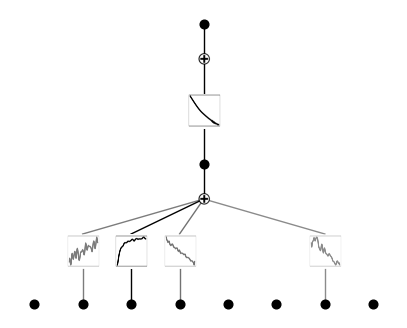

In [14]:
model.plot()

In [15]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

# 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)


layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-9.686622070148587e-05, 0.00042565877083688974, 0.0009742705733515322, 0.0015592299168929458, 0.002186108147725463, 0.0028462251648306847, 0.0035089803859591484, 0.004163836129009724, 0.0048557245172560215, 0.005600399803370237, 0.006414770148694515, 0.007231938187032938, 0.008041564375162125, 0.008884411305189133, 0.009761607274413109, 0.010649451054632664, 0.011508362367749214, 0.012371055781841278, 0.013265155255794525, 0.01418402697890997, 0.015090574510395527, 0.015991197898983955, 0.01691739819943905, 0.017895616590976715, 0.018858643248677254, 0.019815340638160706, 0.02084408700466156, 0.021967098116874695, 0.023093219846487045, 0.02418248914182186, 0.025245901197195053, 0.02637007087469101, 0.02750735729932785]


step11. KAN symbolification

fixing (0,0,0) with 0
fixing (0,1,0) with x, r2=0.7387272119522095, c=1
fixing (0,2,0) with x, r2=0.6808170676231384, c=1
fixing (0,3,0) with x, r2=0.9876581430435181, c=1
fixing (0,4,0) with 0
fixing (0,5,0) with 0
fixing (0,6,0) with x, r2=0.9060202836990356, c=1
fixing (0,7,0) with 0
fixing (1,0,0) with x, r2=0.9737475514411926, c=1
saving model version 0.6


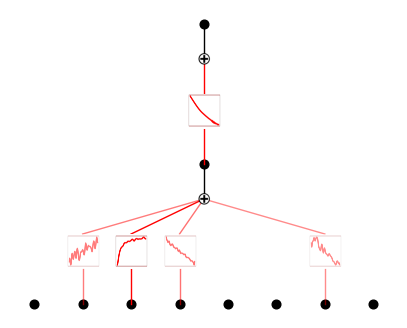

In [16]:
# 자동 모드로 심볼릭 회귀 수행
lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin']   #'x^(-1)', 'x^(-2)', 'x^(-3)', 'x^(-4)'
model.auto_symbolic(lib=lib)
model.plot()

| train_loss: 7.85e-02 | test_loss: 8.35e-02 | reg: 0.00e+00 | : 100%|█| 50/50 [00:04<00:00, 12.42it


saving model version 0.7


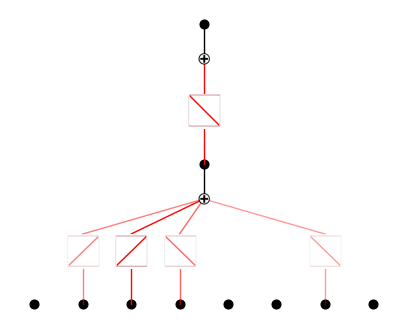

In [17]:
# symbolic 함수로 대체 후 학습
model.fit(dataset, opt="LBFGS", steps=50)
model.plot()

ci 계수들 출력하기

In [24]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

print(model.act_fun[0].coef.shape)
print(model.act_fun[1].coef.shape)  # After pruning, the second layer maintains single node.

torch.Size([8, 1, 33])
torch.Size([1, 1, 33])


2

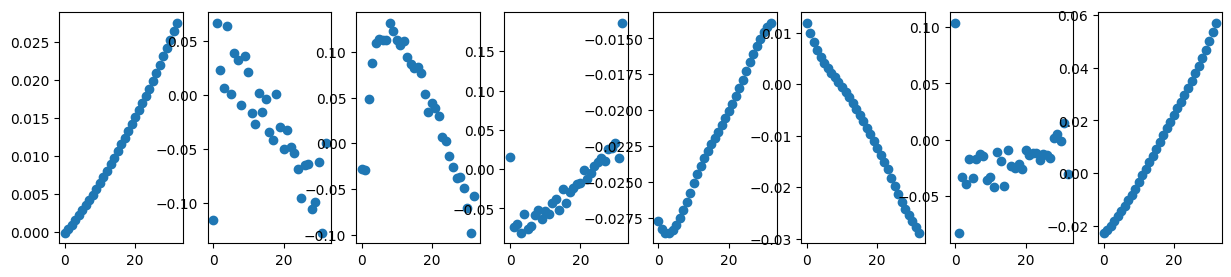

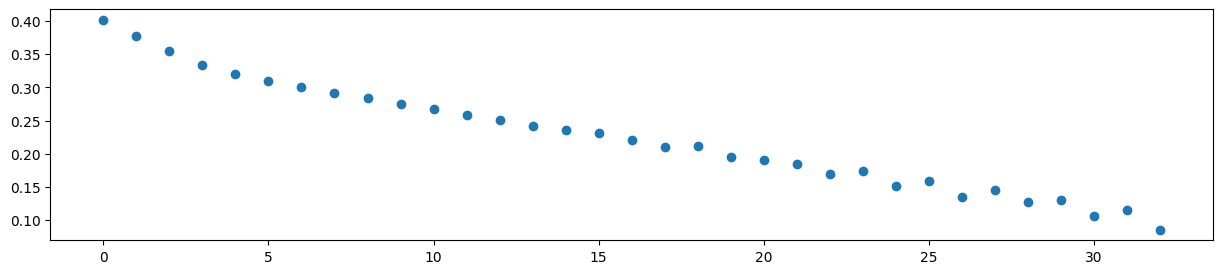

In [26]:
for act_fun in model.act_fun:
    ni, no = act_fun.coef.shape[:2]
    coef = act_fun.coef.tolist()
    fig, axs = plt.subplots(nrows=no, ncols=ni, figsize=(15, 3), squeeze=False)
    for idx_in, coef_in in enumerate(coef):
        for idx_out, coef_node in enumerate(coef_in):
            ax = axs[idx_out, idx_in]
            ax.scatter(list(range(len(coef_node))), coef_node)

Layer 0, Input 2, 4, 6(?) 에서 coefficient의 급격한 변화를 관찰할 수 있음.
그런데 이게 실제로도 그렇다는 걸 알려면 어떻게 해야 하나?

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[8.602492016507313e-05, 0.0005886690923944116, 0.0011220588348805904, 0.0016953275771811604, 0.0023137270472943783, 0.002968153450638056, 0.0036276355385780334, 0.004280824679881334, 0.0049721249379217625, 0.00571681372821331, 0.006531536113470793, 0.007348538842052221, 0.008157012052834034, 0.008997926488518715, 0.009872212074697018, 0.01075678039342165, 0.01161202508956194, 0.012470931746065617, 0.013360947370529175, 0.014275914989411831, 0.015178527683019638, 0.016076017171144485, 0.01699920743703842, 0.017974788323044777, 0.018935397267341614, 0.019889939576387405, 0.020916128531098366, 0.022036589682102203, 0.023159312084317207, 0.024245189502835274, 0.025304654613137245, 0.02642401121556759, 0.0275557991117239]


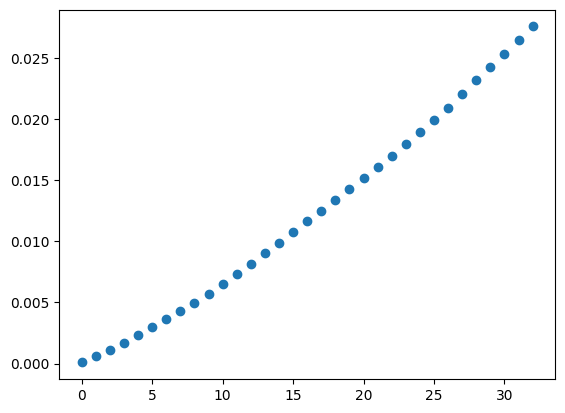

In [22]:
layer_index = 0
input_node_index = 0
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef

specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 1 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.1406480073928833, 0.061478786170482635, 0.03144858404994011, 0.02352113649249077, 0.06438843905925751, 0.005496922880411148, 0.03691459819674492, 0.04602501168847084, 0.007512244395911694, 0.027494512498378754, 0.019048012793064117, 0.0007644608267582953, -0.025459250435233116, 0.007080418057739735, -0.020930014550685883, -0.009186618030071259, -0.011595665477216244, -0.04588659480214119, -0.004519239068031311, -0.02795506827533245, -0.043231088668107986, -0.028223460540175438, -0.0480930432677269, -0.06872519850730896, -0.05969240143895149, -0.09284883737564087, -0.07404603064060211, -0.06748101115226746, -0.11140871793031693, -0.08913641422986984, -0.06148645654320717, -0.14326384663581848, -0.05940797179937363]


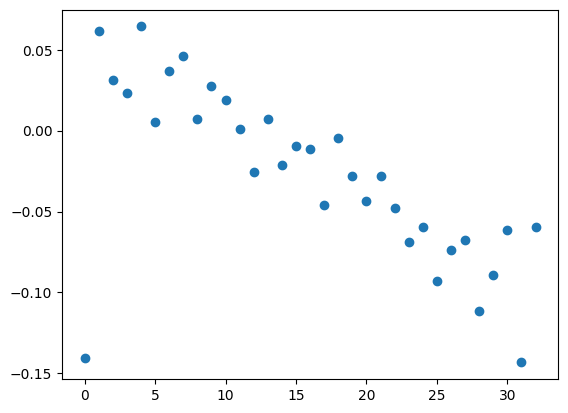

In [23]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 1
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 2 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.028330516070127487, -0.029654689133167267, 0.0469786711037159, 0.08302188664674759, 0.10485531389713287, 0.11400062590837479, 0.11558770388364792, 0.11232694983482361, 0.12985044717788696, 0.11698094755411148, 0.10980556905269623, 0.1067373976111412, 0.11202427744865417, 0.09567946940660477, 0.08766286075115204, 0.07729488611221313, 0.07733564078807831, 0.07173538208007812, 0.056503791362047195, 0.037041645497083664, 0.04717621952295303, 0.0327870175242424, 0.023922579362988472, 0.003358283545821905, 0.0030676494352519512, -0.009995161555707455, -0.023860808461904526, -0.03995777666568756, -0.045018889009952545, -0.05387526750564575, -0.0714288130402565, -0.09207705408334732, -0.05328615382313728]


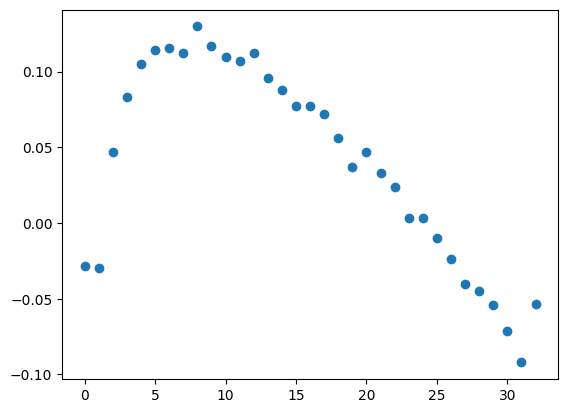

In [24]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 2
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 3 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.010183417238295078, -0.06879118829965591, -0.08595471829175949, -0.08169157058000565, -0.06609679013490677, -0.07203087210655212, -0.08069076389074326, -0.06402003020048141, -0.05344916135072708, -0.06969001889228821, -0.058120325207710266, -0.05678838491439819, -0.050906870514154434, -0.041126322001218796, -0.051375310868024826, -0.029707249253988266, -0.04084870591759682, -0.031199630349874496, -0.02629043720662594, -0.01782619208097458, -0.018793364986777306, -0.001032753032632172, -0.01312839426100254, -0.0014731058618053794, 0.009655791334807873, 0.008559929206967354, 0.02027759701013565, 0.011659515090286732, 0.031128203496336937, 0.03328516334295273, 0.03619588539004326, 0.030270442366600037, 0.14720211923122406]


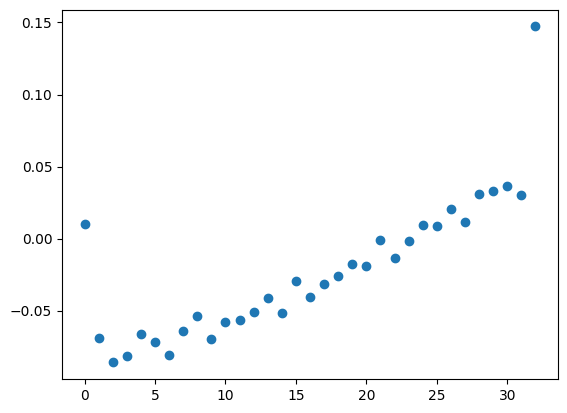

In [25]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 3
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 4 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.02751716412603855, -0.028096675872802734, -0.028368109837174416, -0.028398264199495316, -0.028223218396306038, -0.027877239510416985, -0.02742844633758068, -0.026902927085757256, -0.026335647329688072, -0.025686725974082947, -0.02501467987895012, -0.024381743744015694, -0.02381725236773491, -0.02327893115580082, -0.02276846021413803, -0.022308211773633957, -0.0218547023832798, -0.02139982022345066, -0.02092711254954338, -0.02045149728655815, -0.019955750554800034, -0.019446134567260742, -0.018915904685854912, -0.018343061208724976, -0.01774129644036293, -0.017111193388700485, -0.01651676930487156, -0.01594507321715355, -0.015407499857246876, -0.014909702353179455, -0.014480533078312874, -0.014125117100775242, -0.013846860267221928]


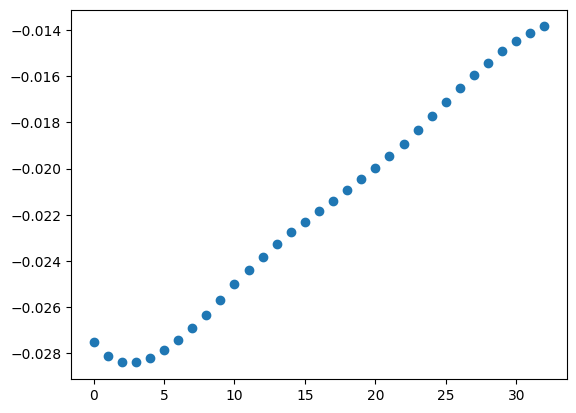

In [26]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 4
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 5 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.012318266555666924, 0.010423491708934307, 0.008703896775841713, 0.007187842857092619, 0.0058365073055028915, 0.0046547758392989635, 0.0036010793410241604, 0.002651377348229289, 0.0017397153424099088, 0.0007998397340998054, -0.00014143607404548675, -0.0011270407121628523, -0.002155483001843095, -0.0033026845194399357, -0.0044478666968643665, -0.005620416719466448, -0.0068429261445999146, -0.008122182451188564, -0.009405609220266342, -0.010706507600843906, -0.012029075063765049, -0.013390935026109219, -0.014731003902852535, -0.016235968098044395, -0.017887484282255173, -0.01956847310066223, -0.02116880752146244, -0.022658687084913254, -0.024036210030317307, -0.02526336908340454, -0.026449482887983322, -0.02761286310851574, -0.028761202469468117]


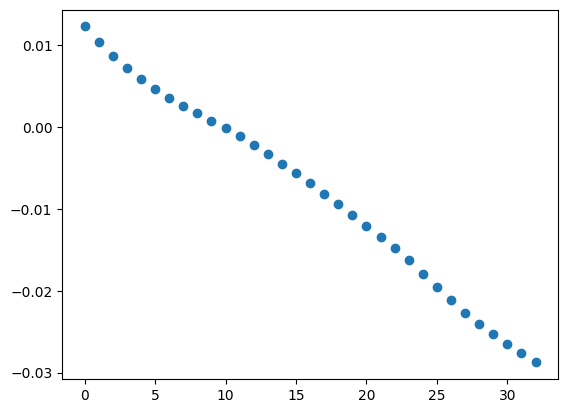

In [27]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 5
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 6 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.0819738581776619, -0.06816377490758896, -0.027424097061157227, -0.03936154395341873, -0.014772895723581314, -0.0442950576543808, -0.021322118118405342, 0.0033459095284342766, -0.009299516677856445, -0.034115005284547806, -0.03850042074918747, -0.047126639634370804, -0.0013539912179112434, -0.012549207545816898, -0.043810874223709106, -0.012214234098792076, -0.02652188017964363, -0.02412966825067997, -0.020608140155673027, -0.014929172582924366, -0.008351889438927174, -0.017900751903653145, -0.017615878954529762, -0.01907763071358204, -0.016131550073623657, -0.006485069170594215, -0.01015732903033495, -0.01797456294298172, -0.0012729051522910595, 0.002735638525336981, -0.003081242786720395, 0.01574612781405449, -0.036502618342638016]


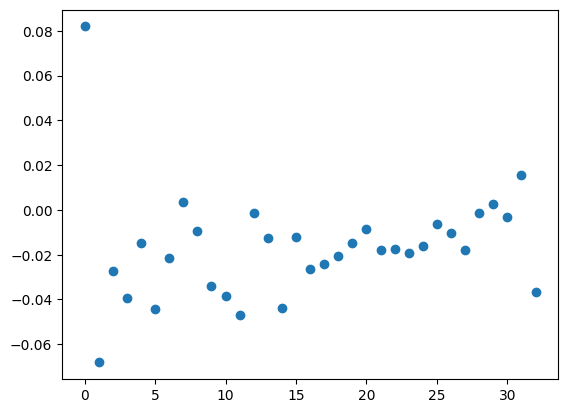

In [28]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 6
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 7 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.022565394639968872, -0.021379683166742325, -0.01991697959601879, -0.018274281173944473, -0.01642117090523243, -0.01444209087640047, -0.012324897572398186, -0.010228218510746956, -0.008148357272148132, -0.005835953168570995, -0.003364472184330225, -0.0007138648070394993, 0.001768291462212801, 0.004303027875721455, 0.006720487494021654, 0.009358312003314495, 0.01200931053608656, 0.014673290774226189, 0.017234425991773605, 0.0197945237159729, 0.022414831444621086, 0.024938225746154785, 0.027479015290737152, 0.030042048543691635, 0.03270404040813446, 0.03552830219268799, 0.03831900656223297, 0.04120665416121483, 0.044057197868824005, 0.047176577150821686, 0.05047876387834549, 0.05391213670372963, 0.05735005810856819]


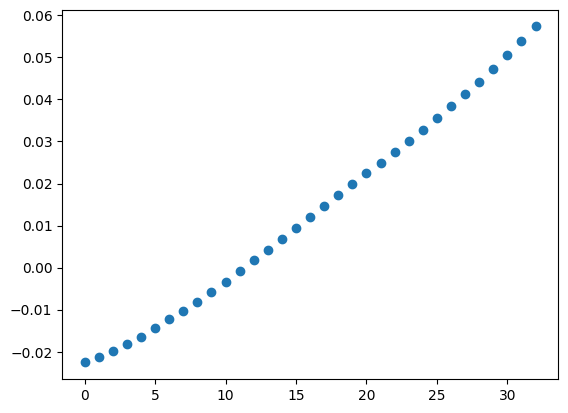

In [29]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 7
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 1의 전체 ci tensor 크기 
torch.Size([1, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[-0.5535923838615417, 1.0291049480438232, 0.48713529109954834, 0.4328785836696625, 0.3239111304283142, 0.29418277740478516, 0.2519196569919586, 0.23066255450248718, 0.21736948192119598, 0.1992894411087036, 0.20385389029979706, 0.18457621335983276, 0.17197656631469727, 0.20926252007484436, 0.16944874823093414, 0.15566617250442505, 0.18524280190467834, 0.1693645715713501, 0.14445821940898895, 0.1663961410522461, 0.16631801426410675, 0.1396959125995636, 0.15002992749214172, 0.15709222853183746, 0.13985221087932587, 0.12755054235458374, 0.14411279559135437, 0.14221665263175964, 0.1190028041601181, 0.14511923491954803, 0.10056918114423752, 0.15508578717708588, -0.04404542222619057]


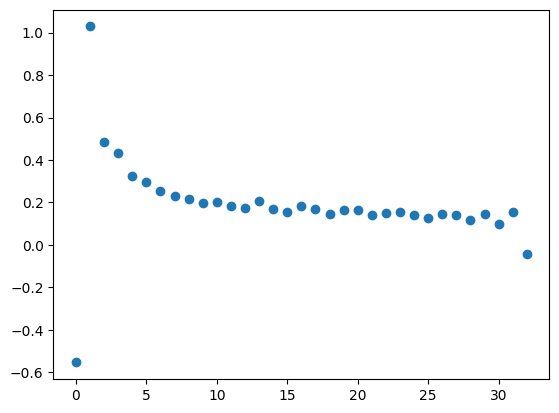

In [30]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 1
input_node_index = 0
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 


specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   

print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

step12. symbolic 수식 출력

In [31]:
# 심볼릭 수식 출력
formula = ex_round(model.symbolic_formula()[0][0], 4)  # ex_round(  , 4) -- 소수점 뒤에 숫자 4개? // 
print("formula =" , formula)  
print('(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)')


formula = -0.0768*x_2 + 0.1033*x_4 + 0.0614*x_7 + 0.1247 + 1.8959*exp(-11.069*x_3)
(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)


step13. KAN이 예측한 수식 정확도 검증을 위한 함수 정의

In [32]:
# validation set으로 성능을 평가하는 함수 만들기
def evaluate_model_performance(model, dataset, scaler_y, phase="validation"):    # phase = validation 아니면 test 이다
    
    
    if phase == "validation":
        input_tensor = dataset['val_input']
        label_tensor = dataset['val_label']
    elif phase == "test":
        input_tensor = dataset['test_input']
        label_tensor = dataset['test_label']
    else:
        raise ValueError("phase는 'validation' 또는 'test'만 가능합니다")
    
    # 예측 수행
    with torch.no_grad():  # 굳이 기울기 계산할 필요 X because 이거는 test 이기에 학습 X --- 시간 더 빠르게 하려고 torch.no_grad()
        pred_norm = model(input_tensor) #input_tensor 는 val_inut or test_input / pred_norm은 그에 대한 출력값
    
    # 역정규화
    pred_real = scaler_y.inverse_transform(pred_norm.cpu().detach().numpy())   # pred_real 은 0.1~0.9 사이의 입력 val_input or test_input을 받고 출력된 값은 다시 역정규화 한 실제 출력값
    label_real = scaler_y.inverse_transform(label_tensor.cpu().detach().numpy()) # label_real은 0.1~0.9 사이의 입력 val_label or test_label을 받고 출력한 값 역정규화
    # inverse_transform 함수는  numpy 를 입력으로 받기 떄문에 pytorch tensor를 cpu로 옮기고 numpy로 변환
    
    # numpy는 cpu에서만 돌아가니까 tensor를 .cpu로 옮기고 그다음 tensor의 추가정보 (numpy 정보 + 어떻게 계산되었는지 식에 대한 정보)를 detach --- 그 다음에 .numpy()를 통해 numpy로 변환
    
    # 성능 지표 계산 from 역정규화된 label_real, pred_real 값들 from val input or test input + numpy에서 계산
    rmse = np.sqrt(mean_squared_error(label_real, pred_real))  # 오차 제곱 평균의 루트
    r2 = r2_score(label_real, pred_real)  #1에 가까울수록 좋다 
    mae = np.mean(np.abs(label_real - pred_real)) # 오차 절댓값들의 평균 -- MAE
    
    print(f"{phase} SET Performance Evaluation") # phase = validation 또는 test 
    print(f"RMSE: {rmse:.4f}")     # f"{변수:포맷코드}"
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    print(f"실제값 평균: {label_real.mean():.4f}")  #label_real의 평균값(실제값)
    print(f"예측값 평균: {pred_real.mean():.4f}")   #pred_real의 평균값(KAN 모델로 예측한 값)
    
    return pred_real, label_real, {'rmse': rmse, 'r2': r2, 'mae': mae}

Step14. Validation data(검증셋)으로 성능 평가

In [33]:
# validation dataset(검증셋)으로 성능 평가 (모델 개발 과정에서)
val_pred, val_actual, val_metrics = evaluate_model_performance(model, dataset, scaler_y, "validation")

#scaler_y : step5 에서 정의한 정규화된 y 변환법
# validation --- 검증셋 이용할거라는 의미 / 나중에 
# val_pred 변수: evaluate_model_performance 함수가 반환한 첫 번째 결과물(pred_real)(모델의 예측값 배열)이 저장
# val_actual 변수: 함수가 반환한 두 번째 결과물(label_real)(실제 정답 값 배열)이 저장
# val_metrics 변수: 함수가 반환한 세 번째 결과물(RMSE, R², MAE가 담긴 딕셔너리)이 저장


validation SET Performance Evaluation
RMSE: 6.2726
R²: 0.9667
MAE: 4.6301
실제값 평균: 48.6630
예측값 평균: 49.0646


step15. KAN이 예측한 수식의 정확도 최종계산 _ using test_input, test_label

In [34]:
# 모든 모델 개발이 완료된 후 최종 한 번만 수행
print("최종 테스트셋 평가")


# 최종 테스트셋 평가(phase만 'test'로 변경하여 테스트 데이터를 사용)(이전에 정의한 evaluate_model_performance 함수를 그대로 사용)
test_pred, test_actual, test_metrics = evaluate_model_performance(
    model, dataset, scaler_y, "test"
)

# test_pred : 모델의 예측값 , test_actual : 실제 정답 값 배열 , test_metrics : (RMSE, R², MAE가 담긴 딕셔너리)

print(f"\nFinal model performance evaluation:")
print(f"Test set RMSE: {test_metrics['rmse']:.4f}")
print(f"Test set R²: {test_metrics['r2']:.4f}")
print(f"Test set MAE: {test_metrics['mae']:.4f}")


최종 테스트셋 평가
test SET Performance Evaluation
RMSE: 5.7214
R²: 0.9706
MAE: 4.3776
실제값 평균: 50.3135
예측값 평균: 50.7504

Final model performance evaluation:
Test set RMSE: 5.7214
Test set R²: 0.9706
Test set MAE: 4.3776


step16. KAN 예측값 / 실제값 그래프

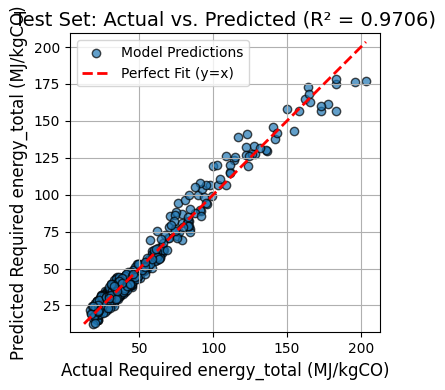

In [35]:
# step14. KAN 예측값 / 실제값 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))  # 도화지 그리기~

# test_actual (x축) vs test_pred (y축) , alpha = 투명도
plt.scatter(test_actual, test_pred, alpha=0.7, edgecolors='k', label='Model Predictions')

# 제일 작은 값, 제일 큰 값 설정
min_val = min(test_actual.min(), test_pred.min())
max_val = max(test_actual.max(), test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit (y=x)')  # y = x 선긋기

# 그래프 제목과 축 레이블 설정
plt.xlabel("Actual " + predicting , fontsize=12)   # Actual 다음에 우리가 보고자 하는 output predicting 변수가 뜸
plt.ylabel("Predicted " + predicting, fontsize=12) # 
plt.title(f'Test Set: Actual vs. Predicted (R² = {test_metrics["r2"]:.4f})', fontsize=14)
plt.legend()
plt.grid(True)  # 격자 on 
plt.axis('equal') # x, y축 스케일을 동일하게 설정
plt.tight_layout()
plt.show()


잔차 플롯 (Residual Plot): 모델의 예측 오차 패턴 분석

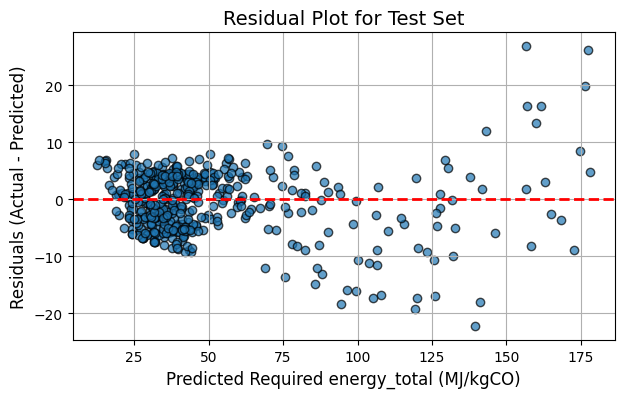

In [36]:
# 1. 잔차 계산 (실제값 - 예측값)
residuals = test_actual - test_pred

# 2. 잔차 플롯 시각화
plt.figure(figsize=(7, 4))

# x축은 예측값, y축은 잔차
plt.scatter(test_pred, residuals, alpha=0.7, edgecolors='k')

# y=0 기준선 추가 (오차가 0인 선)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

plt.xlabel("Predicted "+predicting, fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot for Test Set', fontsize=14)
plt.grid(True)
plt.show()


2. 개별 변수 영향도 플롯 (Partial Dependence Plot): 변수-결과 관계 시각화

--- 모든 입력 변수에 대한 개별 영향도 플롯 ---


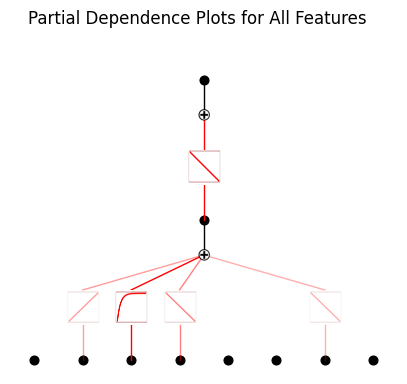

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 1. (NameError 해결) feature_names 리스트를 먼저 정의합니다.
feature_names = [
    "Current density", "Faradaic efficiency", "CO coversion", "Voltage",
    "Electricity cost", "Membrain cost", "Capture energy", "Crossover rate"
]

try:
    print("--- 모든 입력 변수에 대한 개별 영향도 플롯 ---")
    
    # 2. (TypeError 해결) 'vars' 인자 없이 plot() 함수를 호출합니다.
    # 이렇게 하면 8개 변수 각각에 대한 영향도 그래프가 한 번에 그려집니다.
    model.plot()
    
    # 전체 그래프에 대한 제목 설정 (선택 사항)
    plt.suptitle('Partial Dependence Plots for All Features', y=1.02)
    plt.show()

except Exception as e:
    print(f"오류가 발생했습니다: {e}")
    print("이전 단계에서 'model' 객체가 성공적으로 생성되었는지 확인해주세요.")



In [38]:
# step11의 코드를 다시 실행
formula = ex_round(model.symbolic_formula()[0][0], 4)
print("formula=", formula)

# 여기서 맨 왼쪽부터  x_1부터 x_8 


formula= -0.0768*x_2 + 0.1033*x_4 + 0.0614*x_7 + 0.1247 + 1.8959*exp(-11.069*x_3)


-------

------

------------------------------------------------------------------------------------------------------------------------------------------------